# Inference

This notebook enables to predict the closest images of a sketch. 

In [10]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams['axes.titlesize'] = 15

In [11]:
from src.data.loader_factory import load_data
from src.data.utils import default_image_loader
from src.models.encoder import EncoderCNN
from src.models.utils import load_checkpoint, get_model
from src.models.test import get_test_data
from src.models.metrics import get_similarity

In [12]:
class Args:
    dataset = "sketchy_extend"
    data_path = "../io/data/raw"
    emb_size = 256
    grl_lambda = 0.5
    nopretrain = False
    epochs = 1000
    batch_size = 10
    seed = 42
    load = None
    early_stop = 20
    ngpu = 1
    prefetch = 2
    log = "../io/models/"
    log_interval = 20
    attn = True
    plot = False
    cuda = False

args = Args()

In [13]:
torch.set_grad_enabled(False)

In [144]:
NUM_CLOSEST = 4

## Preprocess embeddings to df

In [14]:
import pandas as pd

In [114]:
BEST_CHECKPOINT = '../io/models/1_run-batch_size_10/checkpoint.pth'
EMBEDDING_PATH = '../io/data/processed/embeddings.ending'

## Test

In [107]:
df = pd.read_csv(EMBEDDING_PATH, sep=' ')
images_fnames = df['fnames'].values
images_classes = df['classes'].values
images_embeddings = df['embeddings'].values

In [112]:
len(processed)

17040

## Inference

In [230]:
class Inference():
    
    def __init__(self, model_path, embedding_path):
        
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.loader = default_image_loader

        self.im_net, self.sk_net = get_model(args, model_path)
        
        meta_path = embedding_path.replace('.ending', '_meta.csv')
        df = pd.read_csv(meta_path, sep=' ')
        self.images_fnames = df['fnames'].values
        self.images_classes = df['classes'].values
        
        array_path = embedding_path.replace('.ending', '_array.npy')
        with open(array_path, 'rb') as f:
            self.images_embeddings = np.load(f)
        
    def inference_sketch(self, sketch_fname, plot=True):
        ''' For now just process a sketch but TODO decide how to proceed later'''
        
        sketch = self.transform(self.loader(sketch_fname)).unsqueeze(0) # unsqueeze because 1 sketch (no batch)
        sketch_embedding, _ = self.sk_net(sketch)
        self.get_closest_images(sketch_embedding)
        
        if plot:
            self.plot_closest(sketch_fname)
        
    def get_closest_images(self, sketch_embedding):
        '''
        Based on a sketch embedding, retrieve the index of the closest images
        '''
        similarity = get_similarity(sketch_embedding, self.images_embeddings)
        arg_sorted_sim = (-similarity).argsort()
        print([i for i in arg_sorted_sim[0][0:NUM_CLOSEST + 1]])
        
        print(similarity)
        
        self.sorted_fnames = [self.images_fnames[i].strip(']').strip('[').strip("'") 
                              for i in arg_sorted_sim[0][0:NUM_CLOSEST + 1]]
        self.sorted_labels = [self.images_classes[i]
                              for i in arg_sorted_sim[0][0:NUM_CLOSEST + 1]]
        #print(self.sorted_labels[0])
        
    def plot_closest(self, sketch_fname):
        fig, axes = plt.subplots(1, NUM_CLOSEST + 1)

        sk = mpimg.imread(sketch_fname)
        axes[0].imshow(sk)
        axes[0].set(title='Sketch')

        for i in range(1, NUM_CLOSEST + 1):
            im = mpimg.imread('../' + self.sorted_fnames[i-1])
            axes[i].imshow(im)
            axes[i].set(title='Closest image ' + str(i))

        plt.subplots_adjust(wspace=0.25, hspace=-0.35)

In [231]:
inference = Inference(BEST_CHECKPOINT, EMBEDDING_PATH)

# Results

[11132, 12117, 6180, 8170, 17007]
[[0.19963894 0.23442472 0.1997222  ... 0.21053226 0.23938327 0.23694097]]
[11132 12117  6180  8170 17007]


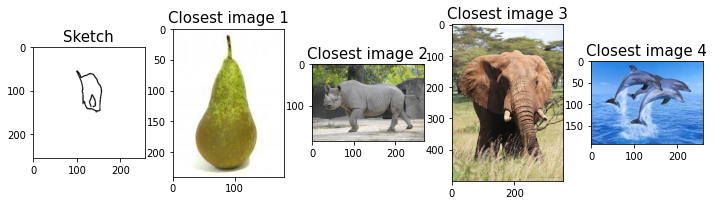

In [232]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/bat/n02139199_1332-1.png'
inference.inference_sketch(sketch_fname, plot=True)

[8103, 3021, 16922, 6497, 3709]
[[0.20232697 0.21597265 0.20839979 ... 0.23926203 0.24569893 0.2343552 ]]
[ 8103  3021 16922  6497  3709]


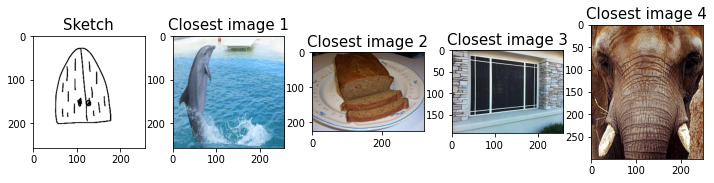

In [233]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/door/n03222176_681-1.png'
inference.inference_sketch(sketch_fname, plot=True)

[10902, 8510, 1161, 14305, 8013]
[[0.23220467 0.24995807 0.20369752 ... 0.23731947 0.28299958 0.23970504]]
(1, 17053)


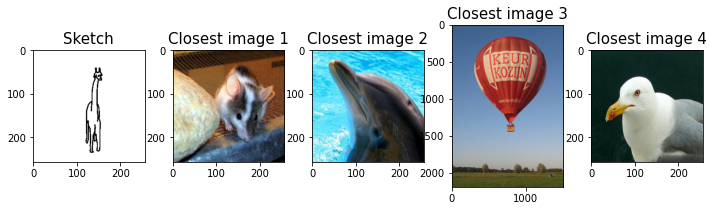

In [221]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/giraffe/n02439033_67-1.png'
inference.inference_sketch(sketch_fname, plot=True)

[10813, 6180, 5798, 960, 594]
[[0.19432313 0.24987528 0.21348446 ... 0.21597893 0.22839146 0.25470912]]
(1, 17053)


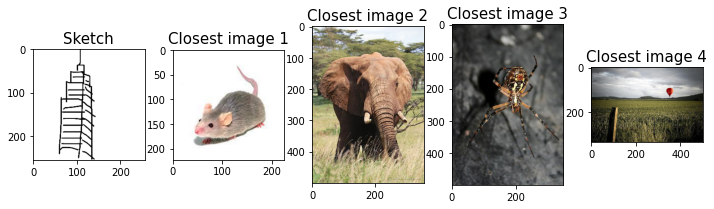

In [222]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/skyscraper/n04233124_498-1.png'
inference.inference_sketch(sketch_fname, plot=True)

[13399, 10299, 9999, 10267, 12703]
[[0.15485693 0.20497797 0.20336056 ... 0.15707997 0.17280441 0.1927949 ]]
(1, 17053)


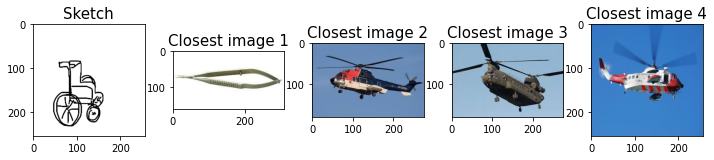

In [223]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/wheelchair/n04576002_150-2.png'
inference.inference_sketch(sketch_fname, plot=True)